## ECON 323 Final Project
### An Analysis of Airbnb Prices Across Popular Countries in Europe

Karina Grewal (Student ID: , Section: 004)

Hrithik Soni (Student ID: 83067918, Section: 003)

Github Repo: https://github.com/Hrithik0015/ECON323_Project

## Contribution
Karina: Introduction, EDA plots, wrote code for Full OLS and Lasso models and provided interpretation of the results. Discussed and wrote conclusion with partner.

Hrithik: Produced some of the EDA plots, wrote code for Ridge, Elastic-Net, and Neural network models and provided interpretation of the results. Discussed and wrote conclusion with partner.

## Introduction
We will be looking into predicting the prices of Airbnb's in popular European destinations based on a variety of factors. The dataset also includes prices when it is the weekend in comparison to weekdays. Therefore this analysis will provide much insight into social/geological factors that reveal booking trends in Airbnb's across Europe. Our analysis aims at finding the most optimal model that accurately predicts airbnb prices in Europe. 

Through our analysis we will be able to find which variables are the most important in predicting prices and therefore will serve as important information when trying to make a budget friendly vacation to Europe. 

## Data Description
This dataset has a wide variety of different variables to look at and create models on. Here we have a list of the variables and their descriptions. 

**The Response Variable**
* realSum (the total price of the listing)

**Independent Variables**
* room_type: the type of the accommodation 
* room_shared: dummy variable for shared rooms
* room_private: dummy variable for private rooms
* person_capacity: the maximum number of guests 
* host_is_superhost: dummy variable for superhost status
* multi: dummy variable if the listing belongs to hosts with 2-4 offers
* biz: dummy variable if the listing belongs to hosts with more than 4 offers
* cleanliness_rating: cleanliness rating
* guest_satisfaction_overall: overall rating of the listing
* bedrooms: number of bedrooms (0 for studios)
* dist: distance from city centre in km
* metro_dist: distance from nearest metro station in km
* attr_index: attraction index of the listing location
* attr_index_norm: normalised attraction index (0-100)
* rest_index: restaurant index of the listing location
* rest_index_norm: normalised restaurant index (0-100)
* lng: longitude of the listing location
* lat: latitude of the listing location

We decided to remove the following variables:

1. `guest_satisfaction_overall` as there is a chance that this rating may affect both the price of the Airbnb and the other variables in our dataset. For example if a low satisfaction score is given there is a chance that this person had a bad experience with the host and now will give a low score to the host, preventing them from becoming a superhost. To avoid this complication we are removing this variable.
2. `attr_index` and `rest_index` are being removed as we will use their normalized values listed in `attr_index_norm` and `rest_index_norm`.
3. We will also be removing `lat` and `lng` from our analysis. In our analysis we will be looking into creating a model that will try to correctly classify which city an Airbnb is listed in given a list of values for the independent variables. Therefore as the cities given in this dataset are physically very far apart these variables are essentially an answer key for the model. Therefore we remove these variables from our entire analysis. 


## Methods: Prediction
We will be using five types of models in order to try to accurately predict the price of an Airbnb given various other values. 
1. Ordinary Least Squares Regression
    * This is the simplest of our models that will construct a linear relationship between the predictors given and the response variable being Airbnb price. 
2. Lasso Regression
    * This linear model uses a L1 regularization method to find a penalty parameter to improve the predictive power from the regular linear model by constraining some variables. The L1 technique allows some coefficients to shrink to zero.  Thereby this model does variable selection *and* regularization to make the most optimal model. 
3. Ridge Regression
    * Ridge uses a L2 technique to find a penalty parameter to constrain variables within the model, however it does not perform variable selection as it does not shrink those coefficients to zero.  
4. Elastic-Net
    * Elastic Net is a combination of Ridge and Lasso in that it performs regularization and variable selection at the same time by using a combination of L1 and L2 techniques. 
5. Neural Networks
    * This is a model that mimics the way human brains neurons work. It takes in a number of input and builds a network of interconnected hidden inner layers that trains the model. It then in the final step produces an output, which in our case is the price of the Airbnbs. 
    
    
### Model Evaluation
To chose the best model to predict Airbnb prices we will be using test mean squared error. This evaluation metric is calculated with the following formula:

$$MSE = \frac{\sum_{i=1}^{n}(Y_i - \hat{Y_i})^2}{n}$$

It takes the squared error between the predicted and actual values then divides by the number of observations. We are looking to find the model with the lowest MSE metric as that indicates that it was able to most accurately predict the response variable of Airbnb price. 

### Reading data

Loading necessary packages

In [1]:
import opendatasets as od
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import glob, os
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.linear_model import (
    Lasso, Ridge, ElasticNetCV, ElasticNet
)
from sklearn.model_selection import (
    GridSearchCV, RepeatedKFold, GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, GridSearchCV
)
from sklearn.metrics import (
    mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from shapely.geometry import Point
from pathlib import Path
from itertools import cycle
%matplotlib inline

Downloading datasets to a local folder

In [2]:
od.download("https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities")

Skipping, found downloaded files in "./airbnb-prices-in-european-cities" (use force=True to force download)


Our data set is spread out across many different files so a for loop was written to first read each file and then append the data. The files are separated by city and by whether the data is from a weekday or a weekend. Therefore two new columns were added to indicate which city the data line came from and which time period. This dataset also provides us with various columns for dummy variables. The following columns are dummy variables and therefore may be excluded from some exploratory data analysis. 

1. `room_share`  & `room_private` are dummy variables for the column `room_type`
2. `multi` & `biz` are dummy variables to indicate how many offers the host has. 

In [3]:
#trying to download all datasets
path = r'airbnb-prices-in-european-cities' 

# Get the files from the path provided
files = Path(path).glob('*.csv')
dfs = list()

#appending all the different files into dataframes by filename of form city_time
for i, f in enumerate(files):
    data = pd.read_csv(f, index_col=0).assign(City=os.path.basename(f).split('.')[0])
    dfs.append(data)

#Combining into a single dataframe
df = pd.concat(dfs, ignore_index=True)

#splitting the file name into two columns with city name and weekday/weekend time period separate
df[['city', 'time']] = df.City.str.split("_", expand = True)
df = df.drop('City', axis=1)

#preview
df.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,time
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,amsterdam,weekdays
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,amsterdam,weekdays
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,amsterdam,weekdays
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,amsterdam,weekdays
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,amsterdam,weekdays


Checking if there are any missing data in the dataset, we see that we have a complete dataset and therefore we can move forward with our analysis.

In [4]:
print(df.isnull().sum())

realSum                       0
room_type                     0
room_shared                   0
room_private                  0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
attr_index                    0
attr_index_norm               0
rest_index                    0
rest_index_norm               0
lng                           0
lat                           0
city                          0
time                          0
dtype: int64


## Exploratory Data Analysis

#### Creating a European Map of where the data points came from

In [5]:
#Creating coordinates for geopandas to read
df["Coordinates"] = list(zip(df.lng, df.lat))
df["Coordinates"] = df["Coordinates"].apply(Point)

gdf = gpd.GeoDataFrame(df, geometry="Coordinates")

# Grab low resolution world file
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

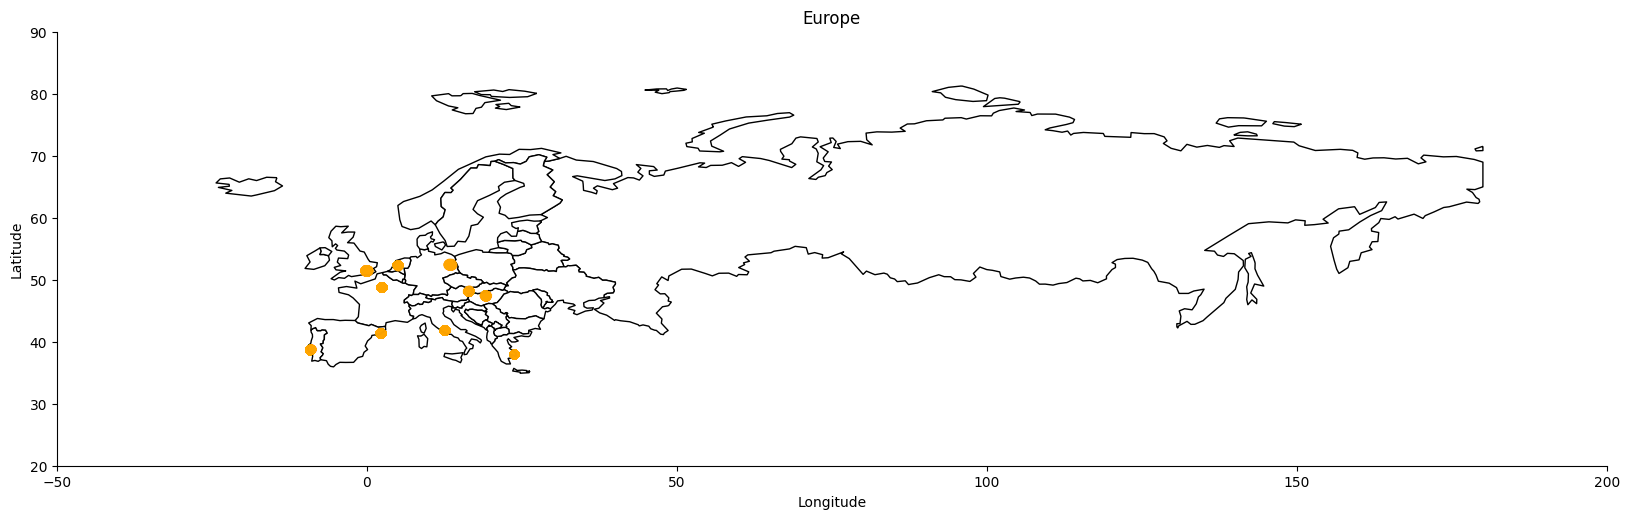

In [6]:
# Plot the cities onto the map
fig, gax = plt.subplots(figsize=(20,20))

#only plotting Europe
world.query("continent == 'Europe'").plot(ax = gax, edgecolor='black', color='white')

gdf.plot(ax=gax, color='orange', alpha = 0.2)

gax.set_xlabel('Longitude')
gax.set_ylabel('Latitude')
gax.set_title('Europe')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)
plt.xlim(-50, 200)
plt.ylim(20, 90)
    
plt.show()

### Counts of values available to us per city

Text(0, 0.5, 'City')

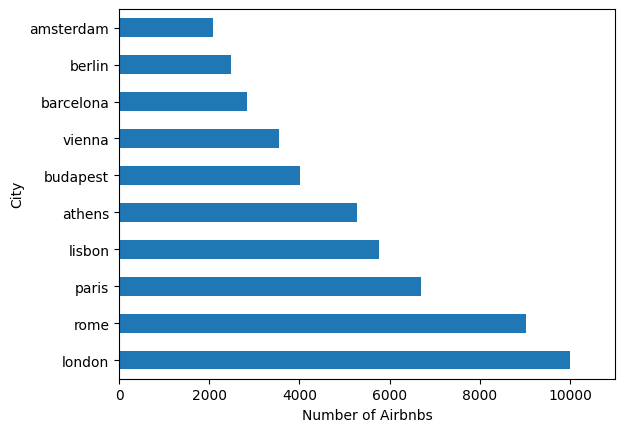

In [8]:
df["city"].value_counts().plot(kind = "barh")

plt.xlim(0, 11000)

plt.xlabel("Number of Airbnbs")
plt.ylabel("City")

We see that London has the most data points while Amsterdam has the least amount of data points in our given data set. 

### Average price per city

Text(0, 0.5, 'Average Price of Airbnb')

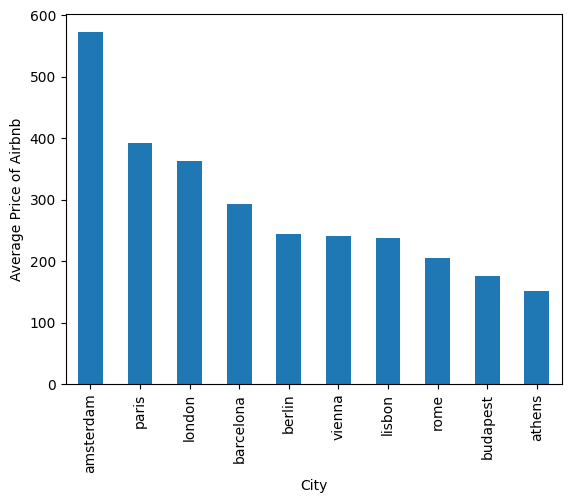

In [10]:
avg_price = df.groupby("city")["realSum"].mean()

avg_price.sort_values(ascending=False).plot.bar()

plt.xlabel("City")
plt.ylabel("Average Price of Airbnb")

We see that there is a clear trend that some cities on average have a higher average prices. Amsterdam has the highest average price, however as indidcated above it has the least number of observations. As the mean function is sensitive to outliers we will check the boxplot to see the distribution of the Airbnb prices below. 

### Distribution of Prices

The models we discuss above are linear models, and they require the assumption that the distribution of the data that is being regressed on must be approximately normal. Therefore we plot the distribution to check that this assumption is valid.

(1.0, 3000.0)

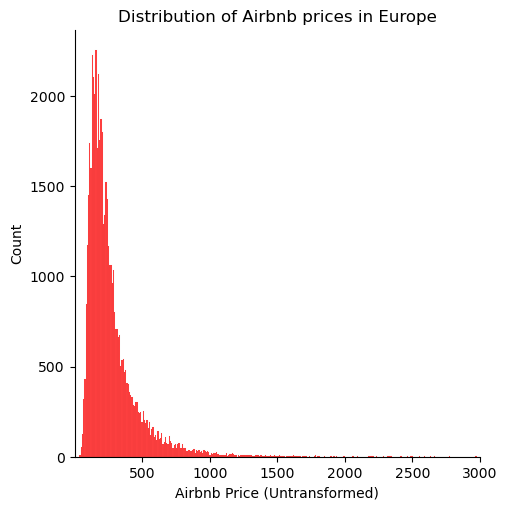

In [35]:
price_dist = sns.displot(df['realSum'], color = 'r')
price_dist.set(title = "Distribution of Airbnb prices in Europe")
price_dist.set_xlabels("Airbnb Price (Untransformed)")
plt.xlim(1,3000)

The plot above shows that the distribution of airbnb prices across Europe is right skewed and is not normal, we try a log transformation on the price to see if we can get a more normal distribution. 

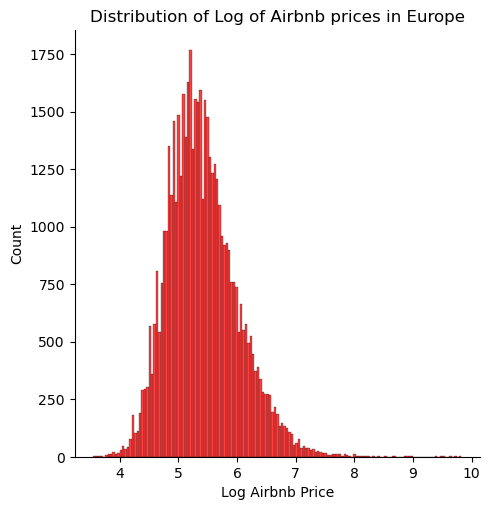

In [36]:
log_dist = sns.displot(np.log(df['realSum']), color = 'r').set(title = "Distribution of Log of Airbnb prices in Europe")
log_dist.set_xlabels("Log Airbnb Price")

Transforming the prices to the log scale shows that the distribution is now approximately normal. The log transformed data satisfies the normality assumption of our linear models, so we will move forward in our analysis using the transformed data.

Text(0, 0.5, 'Log Airbnb Price')

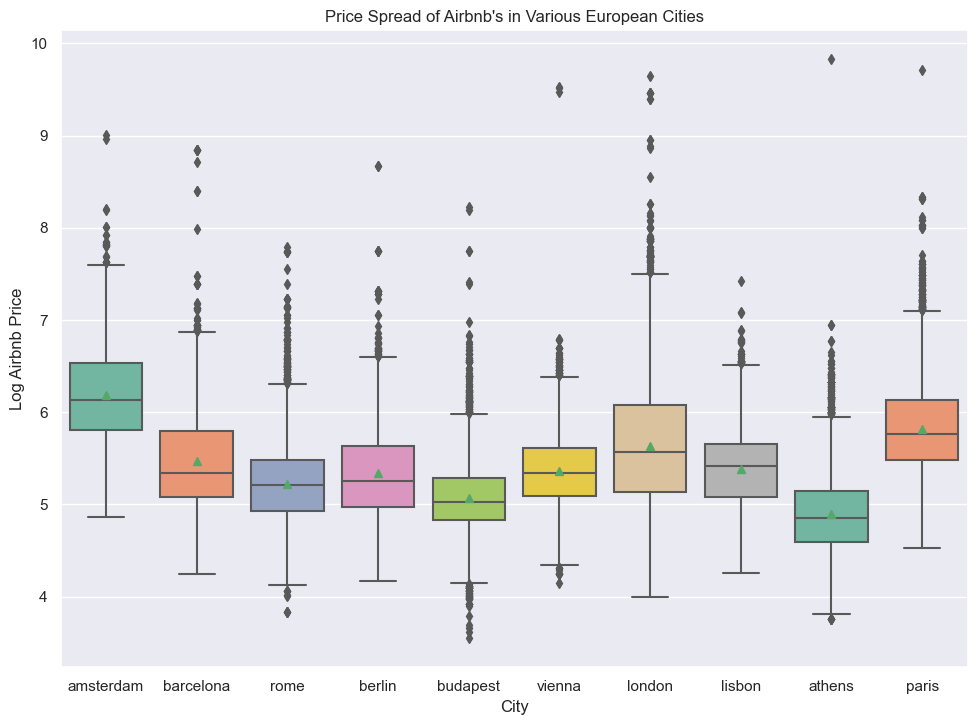

In [11]:
df2 = df.copy()
df2["realSum"] = np.log(df2["realSum"])

sns.set(rc={'figure.figsize':(11.7,8.27)})


sns.boxplot(x="city", y="realSum", data=df2, palette="Set2", showmeans=True)
plt.title("Price Spread of Airbnb's in Various European Cities")
plt.xlabel("City")
plt.ylabel("Log Airbnb Price")

The lines in the middle of the boxes indicate the medians, while the green triangle showcases the mean Airbnb price for that city on the samples collected. Here we have taken the log of the Airbnb Prices in order to make the data normal as it was shown to be right skewed initially. We see that Amsterdam's mean and median prices are the highest in comparison to the cities, therefore there is no need to worry if the outliers are creating bias in the prices for that particular city. 

### Correlation heat map

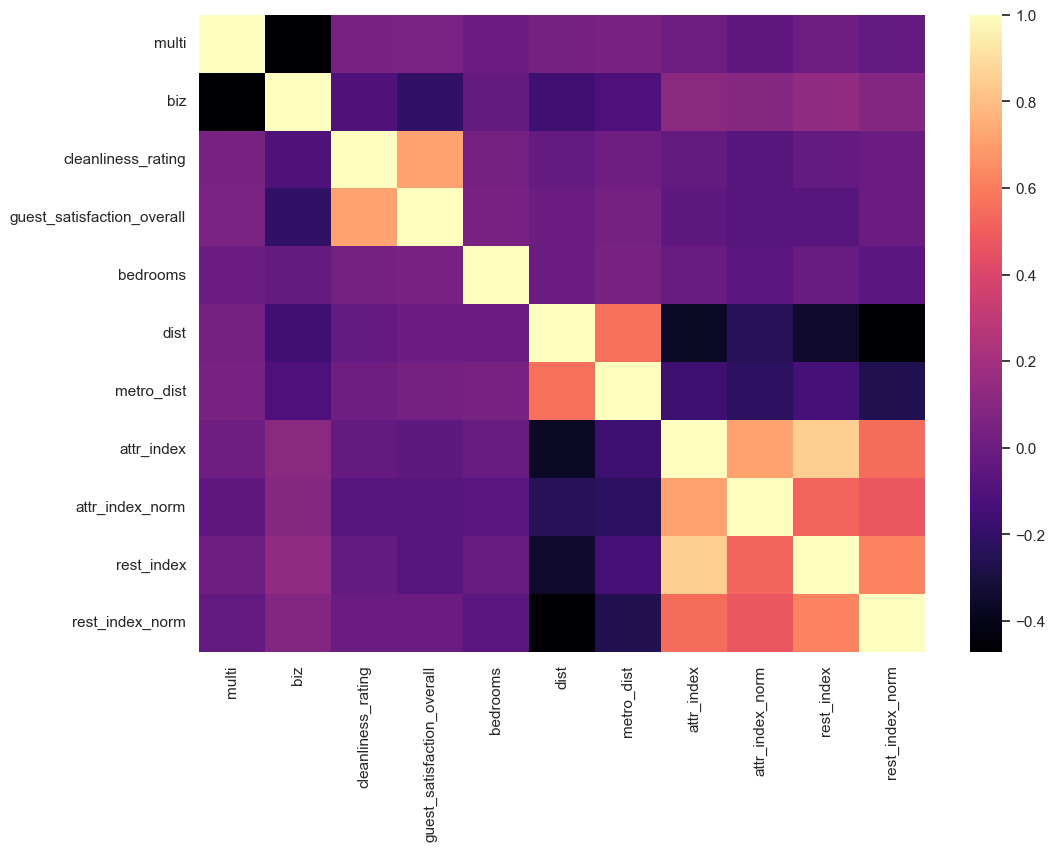

In [38]:
df_heatmap = df.select_dtypes(include=np.number).iloc[:,2:-2]
df_heatmap

sns.heatmap(df_heatmap.corr(), annot = False, cmap = 'magma')
plt.show()

Here we see that many variables are correlated with each other. For example `attr_index`, `attr_index_norm`, `rest_index`, `rest_index_norm`. These variables correspond to a score and their normalized versions of that score (moved onto a scale of 0-100). We see that the normalized version of the variables have lower correlation with each other and therefore we will use the two normalized variables and drop the other two in our analysis further.  

#### Plotting Continuous Variables

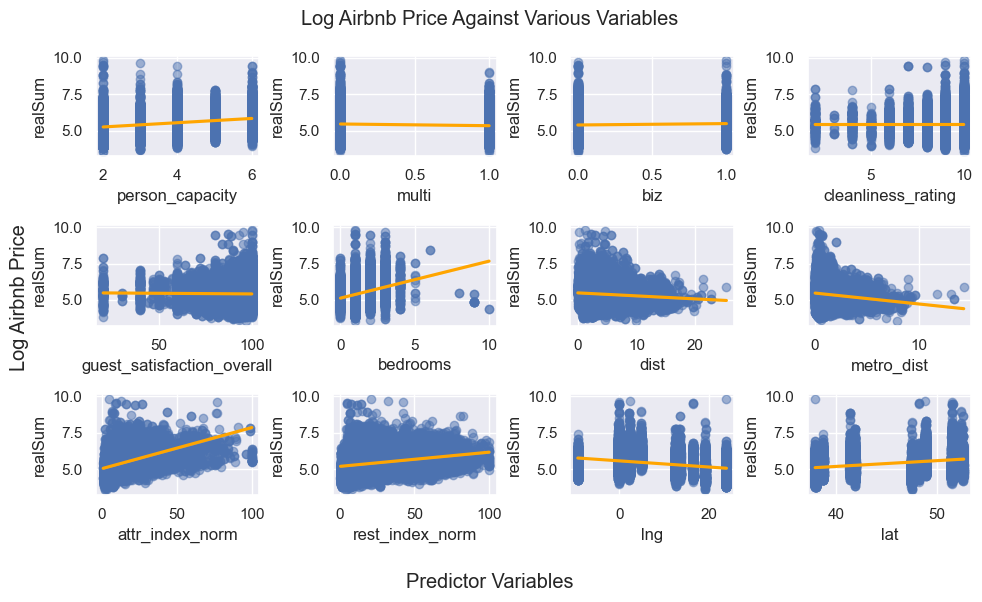

In [13]:
display_df = df[['realSum','person_capacity','multi', 'biz', 'cleanliness_rating', 
                   'guest_satisfaction_overall', 'bedrooms', 'dist',
                   'metro_dist','attr_index_norm', 'rest_index_norm', 'lng', 'lat']]

fig, ax = plt.subplots(3, 4 ,figsize=(10,6))

#for loop to display a different predictor on each subplot
for i,col in enumerate(display_df.columns[1:]):
    if (i < 4):
        x = 0
        sns.regplot(x=display_df[col], y=np.log(display_df['realSum']), ax=ax[x, i], scatter_kws={"alpha": 0.5},line_kws={"color": "orange"})
    elif (i < 8):
        x = 1
        sns.regplot(x=display_df[col], y=np.log(display_df['realSum']), ax=ax[x, i-4], scatter_kws={"alpha": 0.5},line_kws={"color": "orange"})
    elif (i < 12):
        x = 2
        sns.regplot(x=display_df[col], y=np.log(display_df['realSum']), ax=ax[x, i-8], scatter_kws={"alpha": 0.5},line_kws={"color": "orange"})

        
fig.suptitle('Log Airbnb Price Against Various Variables')
fig.supxlabel("Predictor Variables")
fig.supylabel("Log Airbnb Price")
fig.tight_layout()

plt.show()

We see from the orange line whether or not the log price has a postive, negative or no relationship with the log Airbnb price. A positive relationship will have an upward sloping linear regression line, while a negative relationship will be shown with a downward sloping line. We can also see that there are many variables that are binary or that have multiple levels rather than being continuous. For example `multi` and `biz` are binary. Therefore we will explore these variables with more box plots. 

### Plotting Discrete Variables against Price

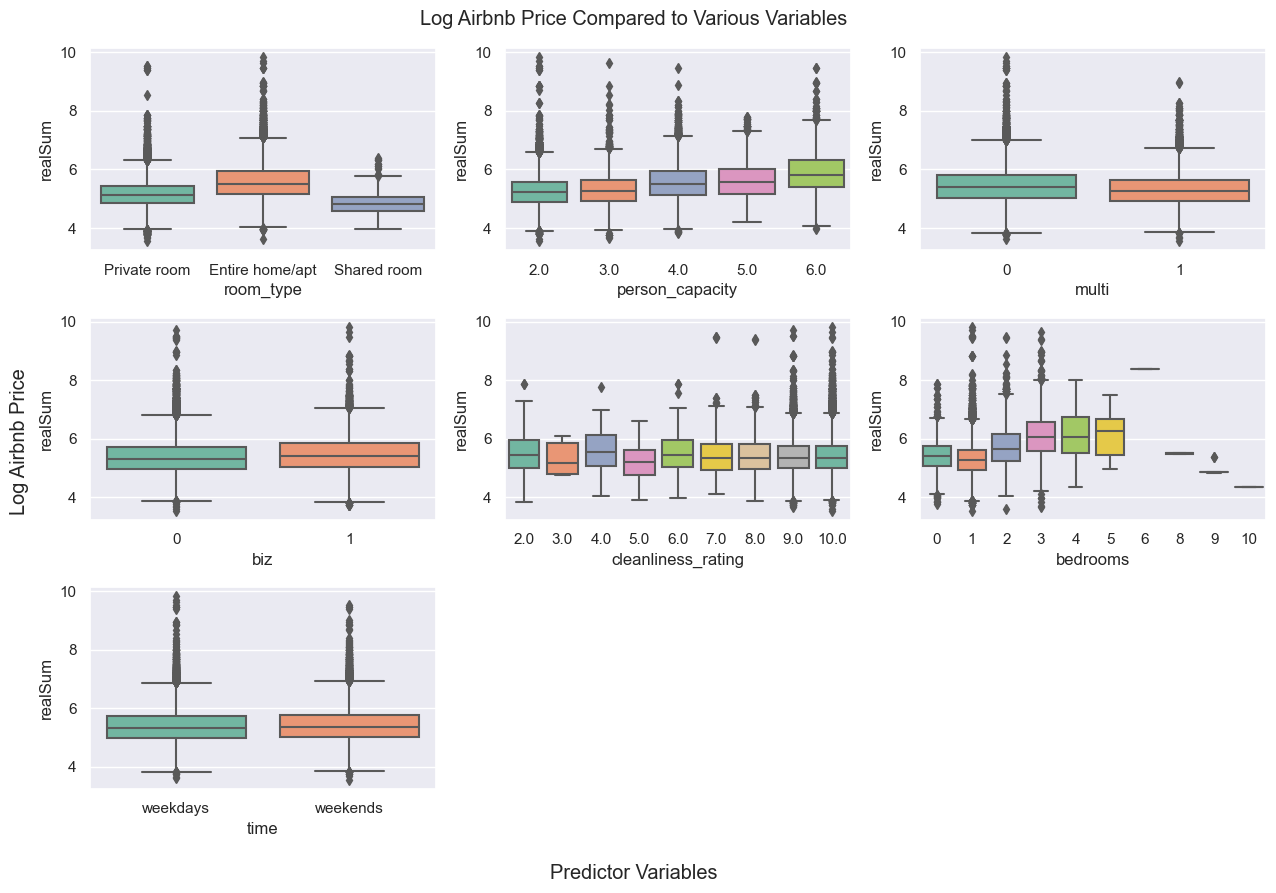

In [14]:
discrete_df = df[['realSum','room_type', 'person_capacity','multi', 'biz', 'cleanliness_rating', 
                   'bedrooms', 'time']]

fig, ax = plt.subplots(3, 3 ,figsize=(13,9))

#delete extra ax
fig.delaxes(ax[2,1])
fig.delaxes(ax[2,2])

#for loop to display a different predictor on each subplot
for i,col in enumerate(discrete_df.columns[1:]):
    if (i < 3):
        x = 0
        sns.boxplot(x=discrete_df[col], y=np.log(discrete_df['realSum']), palette="Set2", ax=ax[x,i])
    elif (i < 6):
        x = 1
        sns.boxplot(x=discrete_df[col], y=np.log(discrete_df['realSum']), palette="Set2", ax=ax[x,i-3])
    elif (i < 12):
        x = 2
        sns.boxplot(x=discrete_df[col], y=np.log(discrete_df['realSum']), palette="Set2", ax=ax[x,i-6])


fig.suptitle('Log Airbnb Price Compared to Various Variables')
fig.supxlabel("Predictor Variables")
fig.supylabel("Log Airbnb Price")
fig.tight_layout()

plt.show()

Here we see that the medians for every levels across all the predictor variables are quite similar as the boxplots overlap each other quite a bit. 

## Methods

### Prediction

Splitting dataset into training and testing datasets (75/25 split) and creating dummy variable for categorical explanatory variables.

In [8]:
x = df.drop(["Coordinates", "realSum", "attr_index", "rest_index", 
             "guest_satisfaction_overall", "lat", "lng"], axis=1)

X = pd.get_dummies(data=x, drop_first=True)
X["host_is_superhost"] = X["host_is_superhost"].astype(int)
X = X.drop(["room_shared", "room_private", "person_capacity"], axis = 1)

Y = np.log(df["realSum"])

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.25)

#### 1. Full OLS

Fitting a linear regression model on training dataset (including all variables)

In [9]:
airbnb_ols = linear_model.LinearRegression()
airbnb_ols.fit(x_train, y_train)

LinearRegression()

Using OLS model to get fitted values on testing dataset

In [10]:
airbnb_test_OLS = airbnb_ols.predict(x_test)

Computing out of sample error (Test MSE)

In [11]:
def sample_mse(y_train, y_test):
    return np.sum((y_train-y_test)**2)/len(y_train)

In [12]:
airbnb_OLS_mse = sample_mse(y_test, airbnb_test_OLS)
airbnb_OLS_mse

0.12730865015413304

#### 2. Lasso Regression

Visualizing LASSO path: LASSO coefficients over alpha values

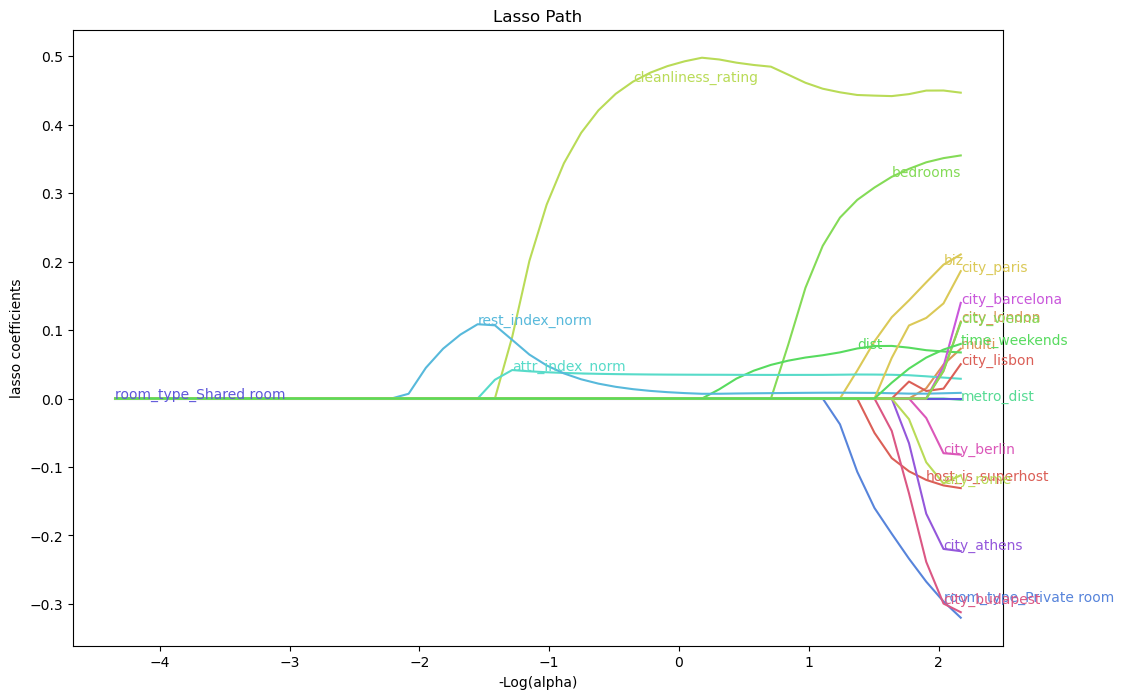

In [13]:
from itertools import cycle
alphas = np.exp(np.linspace(10, -5, 50))
alphas, coefs_lasso, _ = linear_model.lasso_path(x_train, y_train, alphas=alphas, max_iter=10000)
colors = sns.color_palette("hls", 15)

fig, ax = plt.subplots(figsize=(12, 8))
color_cycle = cycle(colors)
log_alphas = -np.log10(alphas)
for coef_l, c, name in zip(coefs_lasso, color_cycle, x_train):
   ax.plot(log_alphas, coef_l, c=c)
   ax.set_xlabel('-Log(alpha)')
   ax.set_ylabel('lasso coefficients')
   ax.set_title('Lasso Path')
   ax.axis('tight')
   maxabs = np.max(np.abs(coef_l))
   i = [idx for idx in range(len(coef_l)) if abs(coef_l[idx]) >= (0.9*maxabs)][0]
   xnote = log_alphas[i]
   ynote = coef_l[i]
   ax.annotate(name, (xnote, ynote), color=c)
    
def fit_and_report_mses(mod, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    return dict(
        mse_train=sample_mse(y_train, mod.predict(X_train)),
        mse_test=sample_mse(y_test, mod.predict(X_test))
    )

Performing 5-fold cross-validation to find the optimal value of $\alpha$ based on MSE. This graph indicates the values of each lasso coefficient with different $\alpha$ values (regularization coefficient) used for the lasso models. 

In [14]:
alphas = np.exp(np.linspace(10, -5, 100))
mse = pd.DataFrame([fit_and_report_mses(linear_model.Lasso(alpha=alpha, max_iter=50000),
                           x_train, x_test, y_train, y_test)
                    for alpha in alphas])

mse["log_alpha"] = -np.log10(alphas)

mse["cv"] = [-np.mean(cross_val_score(linear_model.Lasso(alpha=alpha, max_iter=50000),
                                  x_train, y_train, cv=5, scoring='neg_mean_squared_error'))
          for alpha in alphas]

optimal_log_alpha_lasso = mse.iloc[mse["cv"].idxmin()]["log_alpha"]
optimal_log_alpha_lasso

2.171472409516259

Converting $\alpha$ back to original scale

In [15]:
optimal_alpha_lasso = 1/10**optimal_log_alpha_lasso
optimal_alpha_lasso

0.006737946999085466

Fitting LASSO model using optimal $\alpha$ value

In [16]:
lasso_best = Lasso(alpha=optimal_alpha_lasso)
lasso_best.fit(x_train, y_train)

Lasso(alpha=0.006737946999085466)

Computing out-of-sample error (Test MSE)

In [17]:
airbnb_lasso_mse = sample_mse(y_test, lasso_best.predict(x_test))
airbnb_lasso_mse

0.1551245453571166

#### 3. Ridge Regression

Normalizing the predictor variables (only continuous)

In [18]:
list_numerical = X.columns[3:11]

scaler = StandardScaler().fit(x_train[list_numerical]) 

x_train[list_numerical] = scaler.transform(x_train[list_numerical])

x_test[list_numerical] = scaler.transform(x_test[list_numerical])

Performing 5-fold cross-validation to find the optimal value of $\alpha$ based on MSE

In [19]:
alphas = np.exp(np.linspace(10, -5, 100))
mse = pd.DataFrame([fit_and_report_mses(linear_model.Ridge(alpha=alpha, max_iter=50000),
                           x_train, x_test, y_train, y_test)
                    for alpha in alphas])

mse["log_alpha"] = -np.log10(alphas)

mse["cv"] = [-np.mean(cross_val_score(linear_model.Ridge(alpha=alpha, max_iter=50000),
                                  x_train, y_train, cv=5, scoring='neg_mean_squared_error'))
          for alpha in alphas]

optimal_log_alpha_ridge = mse.iloc[mse["cv"].idxmin()]["log_alpha"]
optimal_log_alpha_ridge

1.3160438845553089

Converting $\alpha$ back to original scale

In [20]:
optimal_alpha_ridge = 1/10**(optimal_log_alpha_ridge)
optimal_alpha_ridge

0.0483009992417301

Computing out-of-sample error (Test MSE)

In [21]:
ridge_best = Ridge(alpha=optimal_alpha_ridge)
ridge_best.fit(x_train, y_train)

airbnb_ridge_mse = sample_mse(y_test, ridge_best.predict(x_test))
airbnb_ridge_mse

0.12730835062184964

#### 4. Elastic Net

Performing 5-fold cross-validation to find the optimal value of $\alpha$ and L1 ratio based on MSE

In [23]:
parameters = dict()
parameters['alpha'] = np.exp(np.linspace(10, -5, 100))
parameters['l1_ratio'] = np.arange(0.01, 1, 0.01)

elastic_model = ElasticNet()

elastic_cv = RandomizedSearchCV(elastic_model, parameters, n_iter = 100, scoring="neg_mean_squared_error", cv=5, 
                                verbose=0, refit=False)

elastic_cv.fit(x_train, y_train)

optimal_l1_ratio = elastic_cv.best_params_.get('l1_ratio')
optimal_elastic_alpha = elastic_cv.best_params_.get('alpha')

print('optimal alpha: %f' % optimal_elastic_alpha)
print('optimal l1_ratio_: %f' % optimal_l1_ratio)

optimal alpha: 0.007840
optimal l1_ratio_: 0.210000


Computing out-of-sample error (Test MSE)

In [24]:
elastic_best = ElasticNet(alpha = optimal_elastic_alpha, l1_ratio = optimal_l1_ratio)
elastic_best.fit(x_train, y_train)

elastic_best_mse = sample_mse(y_test, elastic_best.predict(x_test))

print(elastic_best_mse)

0.1419196697391079


#### 5. Neural Networks

Using 5-fold cross-validation to find the optimal configuration for our neural network model

In [ ]:
neural_model = neural_network.MLPRegressor(hidden_layer_sizes=(40, 100),
                                           activation = 'relu',
                                           solver = 'adam')

neural_model.fit(x_train, y_train)

Due to high computation time, we limit out neural network to two hidden layers. Since our response variable is continuous we choose from identity (linear) or relu activation methods.

In [ ]:
config_grid = {
    'hidden_layer_sizes': [(30,75), (20,50), (10,25)],
    'activation': ['relu', 'identity'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

optimal_grid = GridSearchCV(neural_model, config_grid, n_jobs= -1, cv=5)
optimal_grid.fit(x_train, y_train)

print(optimal_grid.best_params_) 

Computing out-of-sample error (Test MSE)

In [34]:
airbnb_neural_mse = sample_mse(y_test, optimal_grid.predict(x_test))
airbnb_neural_mse

0.10000188957863272

### Comparing All Predictive Models
First we plot the predictor coefficients from different models on the same graph for comparison.

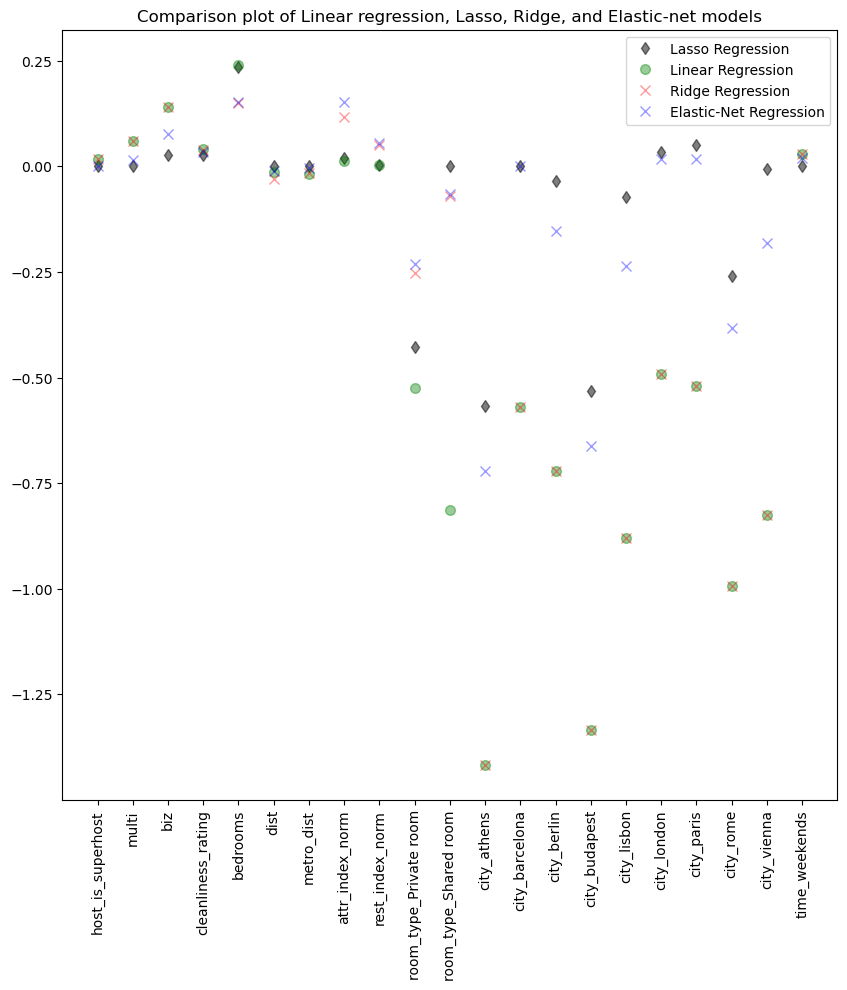

In [25]:
#plot size
plt.figure(figsize = (10, 10))

#add plot for lasso regression
plt.plot(list(x_train), lasso_best.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='black',label=r'Lasso Regression')

#add plot for linear model
plt.plot(list(x_train), airbnb_ols.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')

#add plot for ridge model
plt.plot(list(x_train), ridge_best.coef_,alpha=0.4,linestyle='none',marker='x',markersize=7,color='red',label='Ridge Regression')

#add plot for elastic net model
plt.plot(list(x_train), elastic_best.coef_,alpha=0.4,linestyle='none',marker='x',markersize=7,color='blue',label='Elastic-Net Regression')

#rotate axis
plt.xticks(rotation = 90)
plt.legend()
plt.title("Comparison plot of Linear regression, Lasso, Ridge, and Elastic-net models")
plt.show()

Here we see that the predictors that have parameters that deviate from zero are mostly concentrated on the right side of the graph. Those variables correspond to the dummy variable that indicates which city the Airbnb came from with the base indicator being Amsterdam. That means that when any city dummy variable has a parameter, with all other parameters kept constant, we are looking at that cities Airbnb price in comparison to the baseline city: Amsterdam. Based on the plot above, we see that the coefficients of variables for linear regression model and ridge regression model are very similar whereas the coefficients of lasso and elastic net model deviate quite a bit from the coefficients of the full linear regression model.

#### Counting Number of Non-zero Coefficients

First we print a table of the coefficients shown in the graph above for the four models (all except neural networks).

In [26]:
def series_coef(mod):
    '''
    Prints a Panadas Series that lists all the Coefficients for a specific model
    '''
    return pd.Series(dict(zip(list(x_train), mod.coef_)))

coefs = pd.DataFrame(dict(lasso=series_coef(lasso_best), 
                          linreg=series_coef(airbnb_ols),
                          ridge = series_coef(ridge_best),
                          elastic = series_coef(elastic_best)))

round(coefs, 3)

,lasso,linreg,ridge,elastic
host_is_superhost,0.000,0.017,0.017,0.000
multi,-0.000,0.060,0.060,0.014
biz,0.028,0.141,0.141,0.077
cleanliness_rating,0.027,0.040,0.038,0.034
bedrooms,0.235,0.241,0.151,0.153
dist,0.000,-0.013,-0.030,-0.010
metro_dist,-0.000,-0.018,-0.016,-0.003
attr_index_norm,0.019,0.012,0.117,0.153
rest_index_norm,0.003,0.003,0.052,0.056
room_type_Private room,-0.428,-0.524,-0.252,-0.232


Here we count the number of non-zero coefficients in each model.

In [40]:
model_coefs = [["Full OLS", len(list(np.nonzero(airbnb_ols.coef_))[0])], 
               ["LASSO", len(list(np.nonzero(lasso_best.coef_))[0])], 
               ["Ridge", len(list(np.nonzero(ridge_best.coef_))[0])],
               ["Elastic Net", len(list(np.nonzero(elastic_best.coef_))[0])]]

model_coefs_df = pd.DataFrame(model_coefs, columns=['Model', 'Number of variables'])
model_coefs_df

,Model,Number of variables
0,Full OLS,21
1,LASSO,15
2,Ridge,21
3,Elastic Net,19


Based on the table above, we see that the lasso model uses the fewest predictor variables compared to the other models. Both models, lasso and elastic net, have reduced (penalized) the variables `host_is_superhost` and `city_barcelona` to zero. This suggests that these two variables are not informative in predicting the price of airbnb. Since `city_barcelona` is a dummy variable with the reference category (baseline) as `city_amsterdam`, reducing the `city_barcelona` dummy variable to zero suggests that there is no price difference for airbnbs in Amsterdam and Barcelona. The ridge model uses all the predictor variables since it uses L2 norm which penalize the coefficients but doesn't reduce it to zero.

#### Comparing MSE

In [41]:
model_mse = [["Full OLS", airbnb_OLS_mse], 
             ["LASSO", airbnb_lasso_mse], 
             ["Ridge", airbnb_ridge_mse],
             ["Elastic Net", elastic_best_mse],
             ["Neural Network", airbnb_neural_mse]
            ]
            
model_mse_df = pd.DataFrame(model_mse, columns=['Model', 'Test-MSE'])
model_mse_df

,Model,Test-MSE
0,Full OLS,0.118699
1,LASSO,0.148541
2,Ridge,0.118700
3,Elastic Net,0.134030
4,Neural Network,0.100002


## Discussion

### The Best Models
After fitted several models, we observed that the neural networks model had the lowest test MSE among all the fitted models. This suggests that the neural network model has the highest predictive power and therefore is the best model to use in order to predict Airbnb prices in Europe. However, due to the structure and method implemented by neural networks, this model lacks interpretability. The use of weight vectors and the non-linear activation functions makes it very difficult to interpret the coefficients and its impact on the response variable (airbnb price). Furthermore, neural networks require a lot of computation power and requires regularization to avoid overfitting the data.

Since most of the models have similar test MSE values, elastic net would be another great model to predict airbnb prices. The reason behind picking this model is because of its ability to interpret coefficients and its impact on airbnb price, and having fewer predictor variables in the model (principle of parsimony). To further simplify the model, we can use the lasso model to predict airbnb prices. This model retains interpretability and also further reduces the number of predictors in the model (compared to elastic-net). Although the test MSE for lasso is higher than elastic net, the difference in MSE between these two models is very small. This could possibly be because of the random split of training and test set. 

### Key Takeaways
As discussed earlier, we found that the neural network model performed the best predictions according to the MSE found. Our other models (Lasso, Ridge, Ordinary least squares) are strictly linear models and can only find linear patterns through the data presented. However neural networks is able to detect non-linear relationships. Therefore it can be deduced through this finding that Airbnb prices of various cities in Europe is best predicted using non-linear patterns (based on the given observed variables). 

It is shown in the linear models, which variables have the most importance when plotting, these interpretations are lost when examining the neural network. However, we can see draw some conclusions from the linear prediction models coefficients. As shown in the comparison graph above (the linear model coefficients) the variables containing information on where the city is located has the largest absolute weights relative to the rest of the variables (which hover around zero for all models). The second most absolute weighted variable is the number of bedrooms in the Airbnb. Therefore based on the observed data, the city the Airbnb is found in as well as the number of bedrooms are the most important pieces of information when predicting prices. 

We take a look at the coefficients in the Lasso model to get a sense of which varibles reduce the price of Airbnb's the most. 

In [66]:
def exp(coef):
    return math.exp(coef)-1

lasso_coef = pd.DataFrame(dict(lasso=series_coef(lasso_best))).applymap(exp)
round(lasso_coef.sort_values(by='lasso'),3)

,lasso
city_athens,-0.433
city_budapest,-0.413
room_type_Private room,-0.348
city_rome,-0.229
city_lisbon,-0.071
city_berlin,-0.034
city_vienna,-0.007
host_is_superhost,0.000
city_barcelona,0.000
room_type_Shared room,0.000


Here we exponentiated the coefficients and subtracted 1 to see their impact on the prices of Airbnb's rather than the log price. The coefficient with the smallest value is `city_athens` with a value of $-0.433$. This means that when looking at Airbnb's in Athens compared to Amsterdam, the prices are lower by $43.3\%$. As well the variable `room_type_Private room` has the lowest coefficient of the non-city variables in this dataset. 

So when planning a budget friendly vacation, it is best to book in Athens or Budapest with a small group (or travel by yourself). 

## Limitations & Future Investigation
Since our dataset only covers 9 different cities in Europe it is not an accurate model for cities that are not included. Using this model on cities that are outside these 9 cities would not provide valuable restuls. To further improve this analysis it would be beneficial to use observed data from across Europe or perhaps finding another dataset to merge into the one provided here. 

## References

1. Airbnb prices in European cities. Kaggle. (n.d.). Retrieved April 23, 2023, from https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities 
2. Introduction to economic modeling and Data Science. QuantEcon DataScience. (n.d.). Retrieved April 23, 2023, from https://datascience.quantecon.org/ 